In [28]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import rcParams
import scipy.stats as stats 
import matplotlib.ticker as plticker
from scipy.optimize import curve_fit
import random
from rpy2.robjects import Vector
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## PART I

**The model**: 

-Randomly selects 8 (out of 10) observations of drainage area and baseflow discharge 

-Runs a linear regression fit to the data

-Iterates the process 1000 times and generates an average fit

In [29]:
#Generate df of the observations
#DA is in km^2 and Q is in l/s
d={'DA':[82.450, 27.150, 16.275, 117.275, 382.975,
                              1596.280, 127.675, 9.44982, 2609.570, 3367.000], 
                             'Q':[8.662133483, 0.68431375, 0.868684824, 3.60222113,
                              7.995490543, 24.09174135, 8.038100597, 0.935,
                              119.5290555, 271.842]}
df = pd.DataFrame(data=d, dtype=float)
#df

In [30]:
#randomly select a subset of the df
def some(foo, n):
    return foo.iloc[random.sample(foo.index, n)]
#some(df,8)

In [31]:
# make a new df to store values
runs = pd.DataFrame(columns=['obs_val', 'pred_val','residual','slope','intercept','r2','id'])

In [32]:
for e in range(1000):
    #selects a random sample
    k = some(df,8)

    x = np.array(k['DA'])
    y = np.array(k['Q'])
    
    #fits the data w a linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

    obs_values = y
    pred_values = []
    residuals = []
    obs_da = x
    
    #calculates the predicted values from the linear fit
    for i in x:
        pred_i = float(i) * float(slope) + float(intercept)
        pred_values.append(pred_i)

    #calculates the residual for each pair of observations
    for obs_v,pred_v in zip(obs_values,pred_values):
        Residual = float(obs_v - pred_v)
        residuals.append(Residual)
        
    temp_runs = pd.DataFrame()
    
    temp_runs['obs_da']=obs_da
    temp_runs['obs_val']=obs_values
    temp_runs['pred_val']=pred_values
    temp_runs['residual']=residuals
    temp_runs['slope']=slope
    temp_runs['intercept']=intercept
    temp_runs['r2']=r_value**2
    temp_runs['id']=e
    
    runs = runs.append(pd.DataFrame(data=temp_runs))

In [33]:
runs.describe()

,intercept,obs_da,obs_val,pred_val,r2,residual,slope
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8000.000000
mean,-8.480764,847.844218,45.750407,45.750407,0.861480,-9.059420e-17,0.062550
std,4.354037,1191.073269,84.041093,78.157195,0.042866,3.089269e+01,0.012449
min,-13.714715,9.449820,0.684314,-12.972457,0.830643,-8.237451e+01,0.013520
25%,-12.192799,27.150000,0.935000,-4.904614,0.832829,-4.442078e+00,0.064781
50%,-9.670954,127.675000,8.038101,2.007497,0.840191,5.711995e+00,0.065944
75%,-5.387899,1596.280000,24.091741,92.650482,0.862114,1.219784e+01,0.069209
max,2.872039,3367.000000,271.842000,269.894719,0.992842,6.344345e+01,0.081406


In [34]:
tot_meanslope = runs['slope'].mean()
tot_meanintercept = runs['intercept'].mean()

In [35]:
#split by id
grouped = runs.groupby('id')

#create series with one value for slope, intercept, and r2
temp_slope = grouped['slope'].first()
temp_intercept = grouped['intercept'].first()
temp_r = grouped['r2'].first()

#new data frame with slope, intercept, r2 stored by id
line_data = pd.concat([temp_slope, temp_intercept, temp_r], axis=1)
line_data = pd.DataFrame(line_data, columns=('slope','intercept','r2'))
#line_data

In [36]:
for row in line_data:
    
    m = line_data['slope']
    b = line_data['intercept']
    
    y_values = [(m*x)+b for x in range(3500)]
    x_values = np.arange(len(y_values))

('Average line slope:', 0.06254966363331256, 'intercept:', -8.480763544032866)


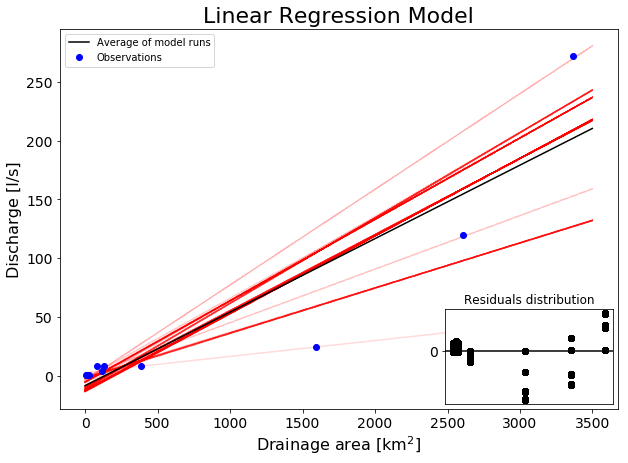

In [55]:
rcParams['figure.titlesize'] = 22
rcParams['axes.titlesize'] = 22
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['figure.subplot.wspace'] = 0.2

print ("Average line slope:", tot_meanslope, "intercept:", tot_meanintercept)

fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, y_values, linestyle='-', color='r', marker='', alpha=0.01)
plt.plot(x_values, (x_values*tot_meanslope)+tot_meanintercept, color='k', 
         label='Average of model runs')
plt.plot(df['DA'], df['Q'], marker='o', color='b', linestyle='', label='Observations')
plt.legend(loc="upper left")

axins = inset_axes(ax, width="30%", height="25%", loc=4)
axins.axhline(color='k')
axins.scatter(runs['obs_da'], runs['residual'], color='k')
axins.set_xticks([])
axins.set_yticks([0])
axins.set_title(label='Residuals distribution', fontsize='12')

ax.set_title('Linear Regression Model')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')
plt.show()

## PART II

**Predicting the discharge** in channels where drainage area can be measured, but discharge cannot:

In [42]:
#df with all measured DAs
WSD = pd.read_csv('DA-QCalc.csv') 
DA = WSD['DA m^2']/1000 #n=58

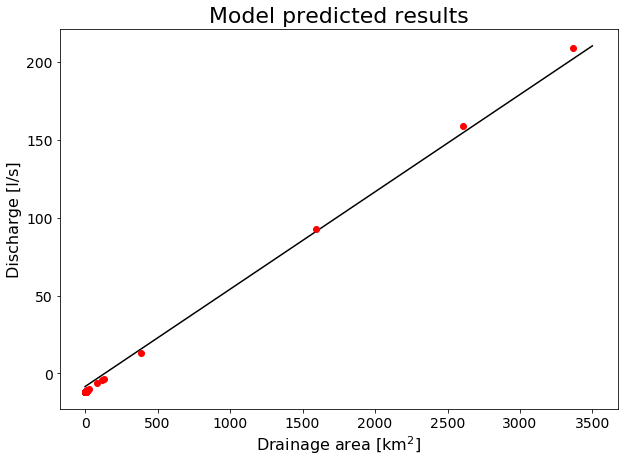

In [60]:
pred_Q = []

#calculates the predicted values from the linear fit
for d in DA:
    pred_d = float(d) * float(slope) + float(intercept)
    pred_Q.append(pred_d)
    
#Plot
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, (x_values*tot_meanslope)+tot_meanintercept, color='k', 
         label='Average of model runs')
plt.plot(DA, pred_Q, marker='o', color='r', linestyle='')

ax.set_title('Model predicted results')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')

plt.show()

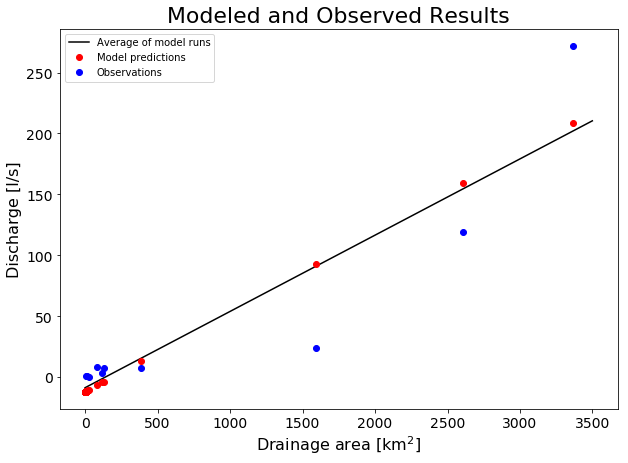

In [61]:
pred_Q = []

#calculates the predicted values from the linear fit
for d in DA:
    pred_d = float(d) * float(slope) + float(intercept)
    pred_Q.append(pred_d)
    
#Plot
fig, ax = plt.subplots(figsize=(10,7))

plt.plot(x_values, (x_values*tot_meanslope)+tot_meanintercept, color='k', 
         label='Average of model runs')
plt.plot(DA, pred_Q, marker='o', color='r', linestyle='',label='Model predictions')
plt.plot(df['DA'], df['Q'], marker='o', color='b', linestyle='', label='Observations')
plt.legend(loc='upper left')

ax.set_title('Modeled and Observed Results')
ax.set_xlabel('Drainage area [km$^2$]')
ax.set_ylabel('Discharge [l/s]')

plt.show()

In [59]:
pred_Q = np.array(pred_Q)
lnr_df = pd.DataFrame(columns=['Drainage area [km$^2$]','Modeled Q [l/s]',
                               'Modeled Q [cm$^3$/s]','Observed Q [l/s]'])
lnr_df['Drainage area [km$^2$]']=DA
lnr_df['Modeled Q [l/s]']=pred_Q
lnr_df['Modeled Q [cm$^3$/s]']=pred_Q*1000
lnr_df['Observed Q [l/s]']=df['Q']
lnr_df

,Drainage area [km$^2$],Modeled Q [l/s],Modeled Q [cm$^3$/s],Observed Q [l/s]
0,82.45000,-6.477169,-6477.169293,8.662133
1,27.15000,-10.102466,-10102.466486,0.684314
2,16.27500,-10.815398,-10815.397896,0.868685
3,117.27500,-4.194150,-4194.149858,3.602221
4,382.97500,13.224321,13224.321466,7.995491
5,1596.28000,92.764850,92764.849692,24.091741
6,127.67500,-3.512358,-3512.357981,8.038101
7,9.44982,-11.262836,-11262.835616,0.935000
8,2609.57000,159.193012,159193.012311,119.529055
9,3367.00000,208.847784,208847.783613,271.842000
